# Homework 3 Group O
Florian Ulbricht 485080

Martin Hahn 484109 

Mattis Rosenkranz 487615

David Andrés Mancera Carrillo 487621


In [224]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sps

In [225]:
# utility functions
def generate_sin(N, f, fs):
    w0 = 2 * np.pi * f / fs
    n = np.arange(N)
    return np.sin(w0 * n)


def plot_waveform(x, title):
    figure, axes = plt.subplots()
    axes.set_title(title)
    axes.plot(x)
    axes.set_ylabel('Amplitude')
    axes.set_ylim([-1.1, 1.1])


def plot_bin_spectrum_magnitude(X, title):
    figure, axes = plt.subplots()
    axes.set_title(title)
    axes.stem(np.abs(X))
    axes.set_xlabel('k')
    axes.set_ylabel('Magnitude')


def plot_frequency_spectrum_magnitude(f, X, title):
    magnitude_db = 20 * np.log10(np.abs(X))

    figure, axes = plt.subplots()
    axes.set_title(title)
    axes.plot(f, magnitude_db)
    axes.set_xscale('log')
    x_ticks = [10 ** i for i in range(int(np.floor(np.log10(f[-1]))) + 1)]
    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_ticks)
    axes.set_xlim(left=10)
    axes.set_xlabel('Frequency (Hz)')
    axes.set_ylabel('Magnitude (dBFS)')
    axes.set_ylim(bottom=-60)

### 1 Square Wave Synthesis

#### a)

Generate and plot square waves with a fundamental frequency of f0 = 100 Hz, a sampling rate of fs = 48 kHz, and a duration of N = 480 samples consisting of 1, 2, 8, and 100 sine components. Generate the signals in the frequency domain by (1) computing the single sided spectrum, (2) mirroring the spectrum under consideration of the DFT symmetry, and (3) obtaining the time signal through the inverse DFT.

#### c)

Loop the time signals from (a) to obtain signals with a duration of 1 s and play back the signals.

The following code is explicitly written for the given exercise assuming that

- N is an even number

- $ \Delta f = f_s / N = f_0 = 100 $

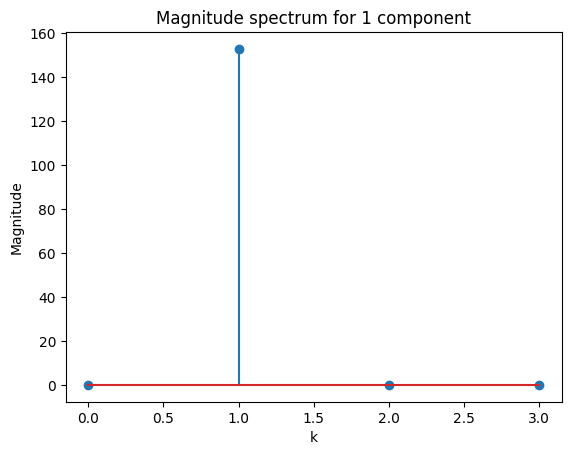

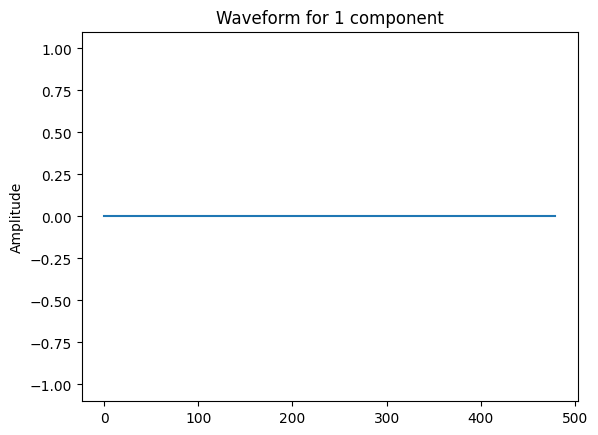

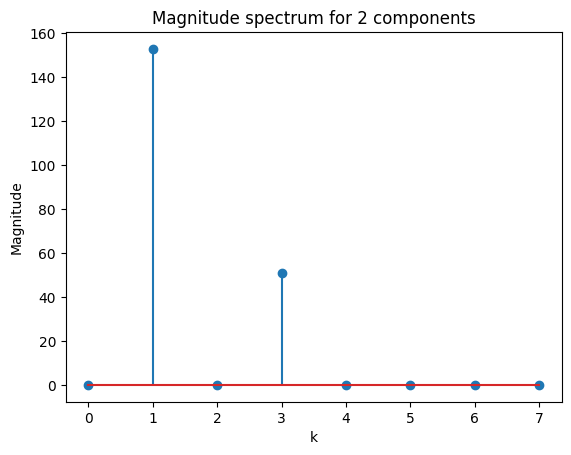

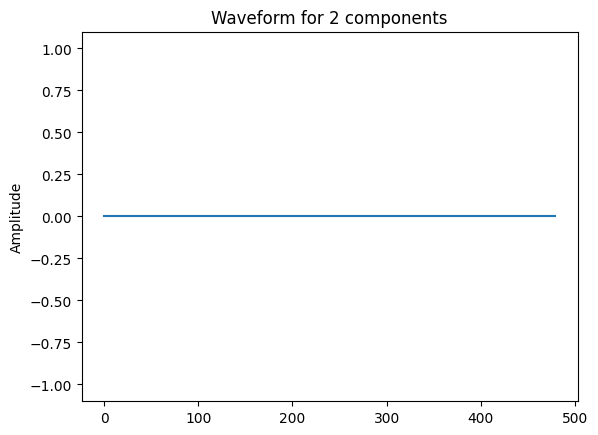

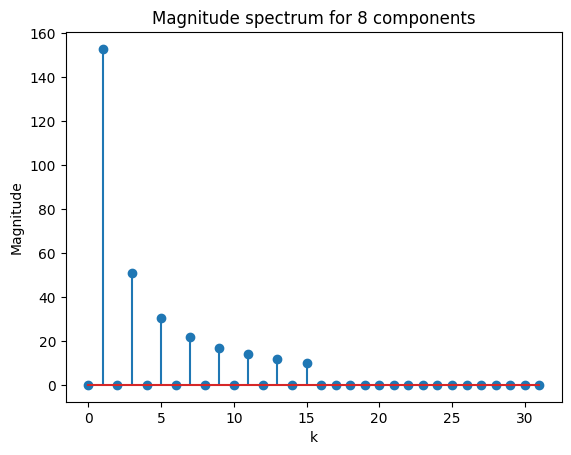

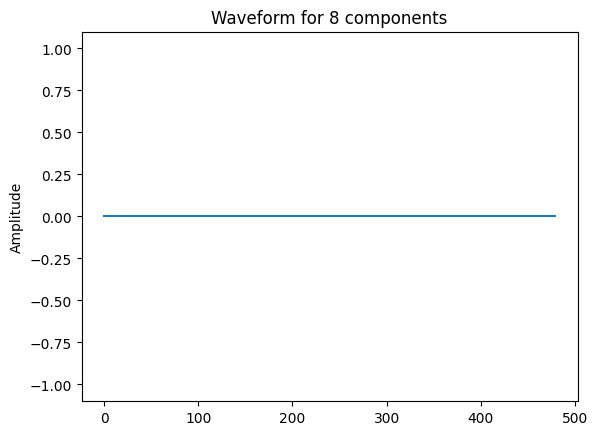

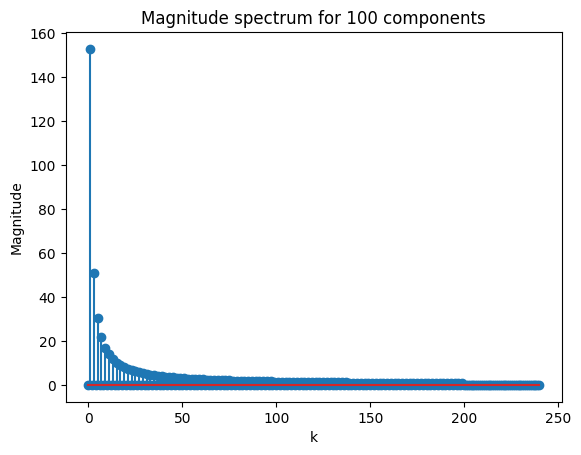

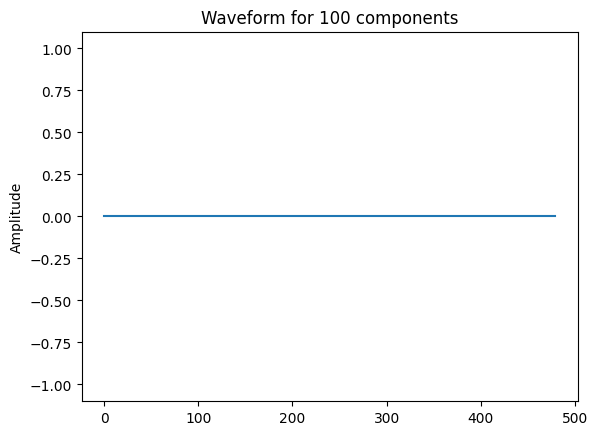

In [226]:
fs = 48_000
f0 = 100
N = 480
N_single_sided = N // 2 + 1
component_amounts = [1, 2, 8, 100]

tile_amount = fs // N


for component_amount in component_amounts:
    X_single_sided = np.zeros(N_single_sided, dtype=complex)

    k_to_fill = np.ones(component_amount, dtype=int) + np.arange(0, component_amount) * 2

    for k in k_to_fill:
        X_single_sided[k] = N / np.pi * np.exp(-1j * np.pi / 2) / k

    X = np.append(X_single_sided, np.flip(X_single_sided[1:-1]))
    x = np.real(np.fft.ifft(X))

    title_suffix = f'for {component_amount} component{"s" if component_amount > 1 else ""}'
    plot_bin_spectrum_magnitude(X_single_sided[:component_amount * 4], f'Magnitude spectrum {title_suffix}')
    plot_waveform(x, f'Waveform {title_suffix}')

    # c)
    x_tiled = np.tile(x, tile_amount)
    filename = f"square wave - {component_amount} sine components.wav"
    sf.write(filename, x_tiled, fs)

#### 2 Signal Flow Graphs

Derive the difference equation for the signal flow graph shown in Fig. 2 using the node signals w1[n] and w2[n].

$$ w_1[n] = x[n] + b w_2[n] + a w_2[n] $$
$$ w_2[n] = c w_1[n] $$
$$ y[n] = e w_2[n] + d x[n] $$

#### 3 Second Order Sections

#### 4 Effect of Time Windows on the Spectrum

Generate a 2 second sine signal with a frequency of 2 kHz and a sampling rate of 16 kHz.
Use a rectangular, triangular and Hann window (scipy.signal.windows) and apply the
windows with two different length (20 periods and 20.25 periods) to the 2 kHz sine signal.
Plot the windows (time signals) and the logarithmic magnitude spectra of the six
windowed sine signals and explain the results.

Hint: multiply the spectra X[k] by 2 / numpy.sum(window) to get comparable results.

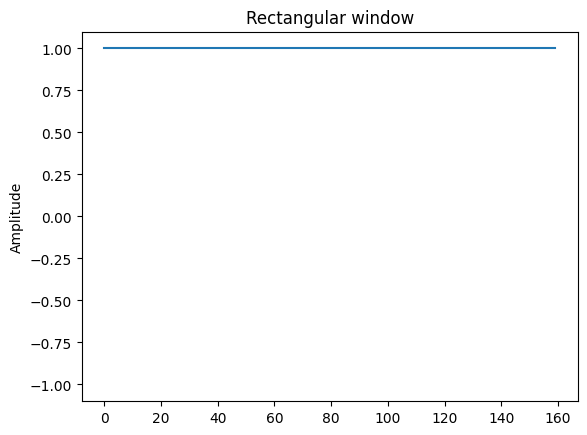

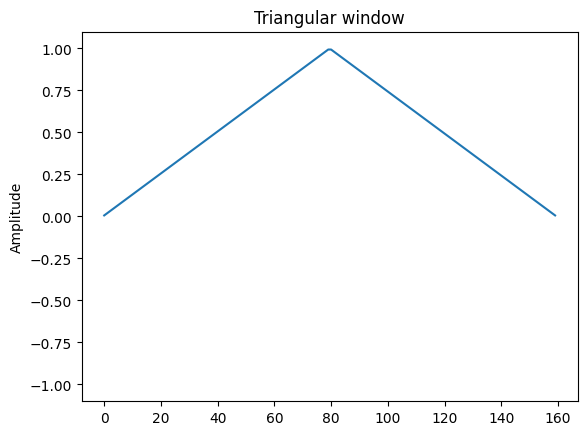

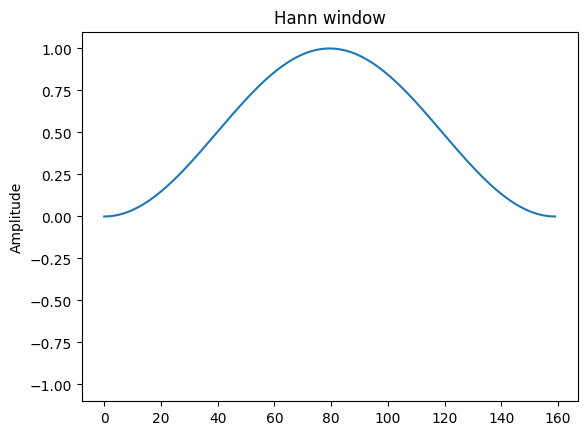

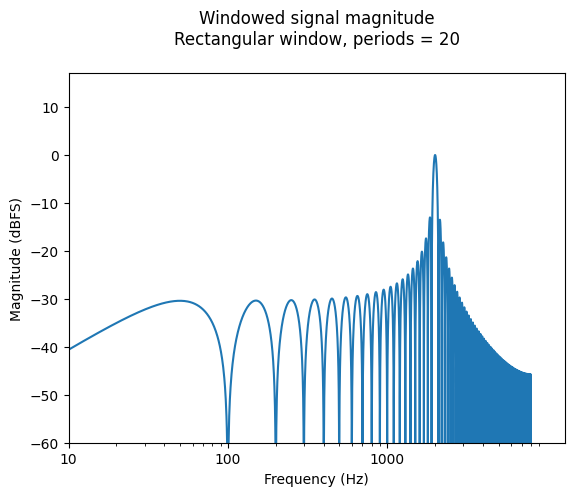

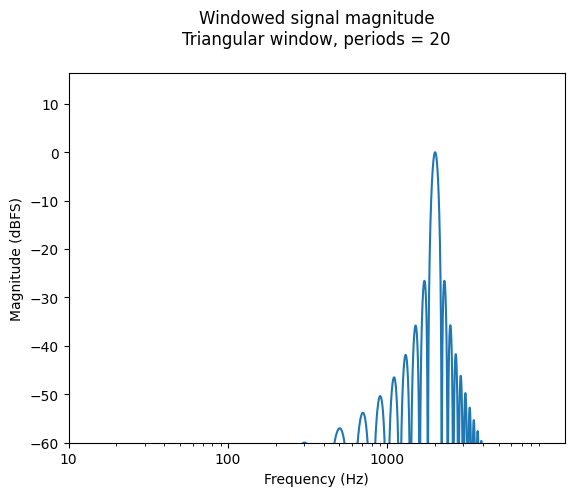

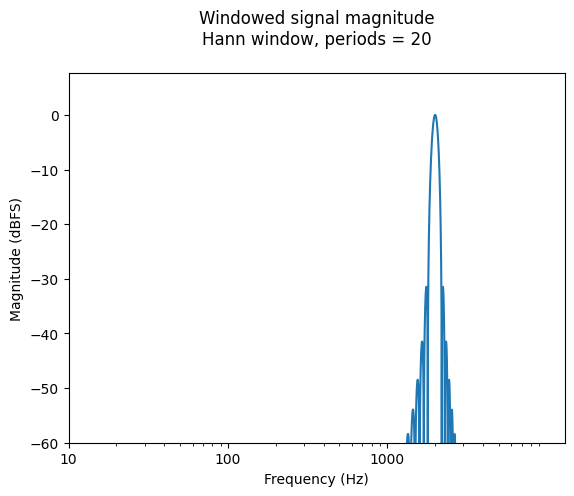

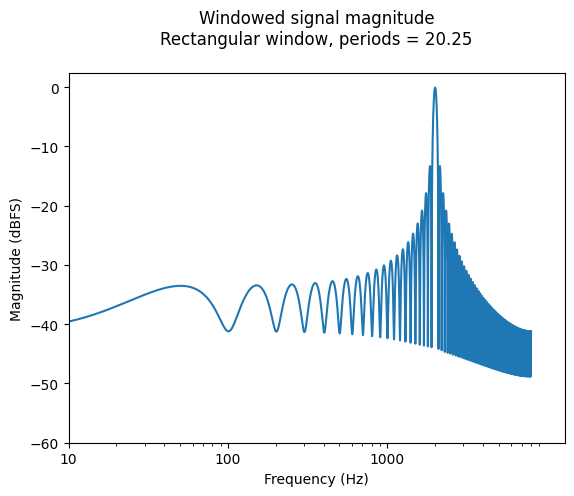

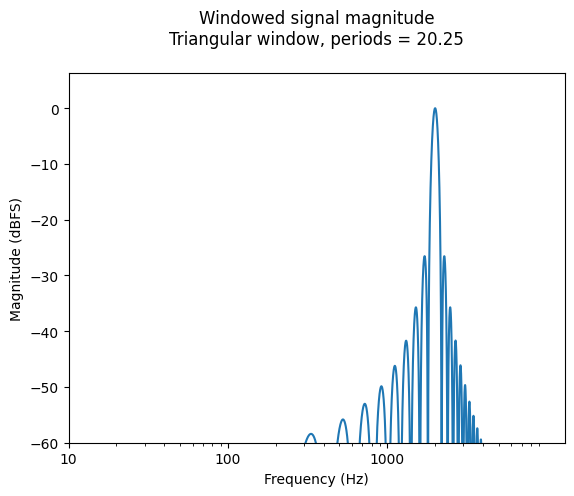

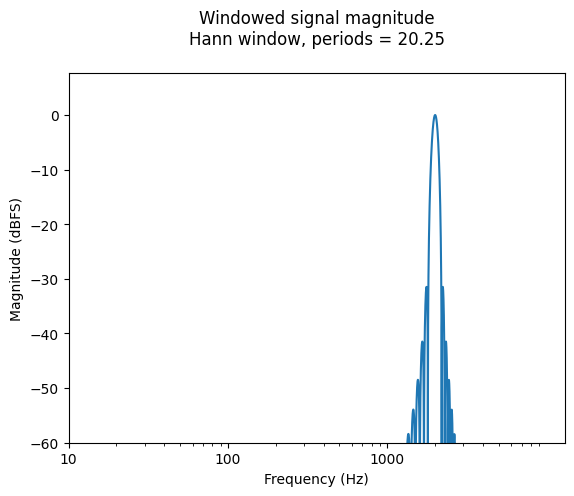

In [227]:
f = 2_000
fs = 16_000
length_seconds = 2
N = fs * length_seconds
window_periods_list = [20, 20.25]

x = generate_sin(N, f, fs)

for window_periods_index, window_periods in enumerate(window_periods_list):
    N_window = int(fs / f * window_periods)
    windows = [
        sps.windows.boxcar(N_window),
        sps.windows.triang(N_window),
        sps.windows.hann(N_window)
    ]
    windows_padded = [np.pad(window, (0, N - N_window)) for window in windows]
    window_names = ['Rectangular', 'Triangular', 'Hann']

    if window_periods_index == 0:
        for window, window_name in zip(windows, window_names):
            plot_waveform(window, f'{window_name} window')

    for window_padded, window_name in zip(windows_padded, window_names):
        x_windowed = np.multiply(x, window_padded)
        f_X = np.fft.rfftfreq(N, 1 / fs)
        X = np.fft.rfft(x_windowed) * 2 / np.sum(window_padded)
        title = f'Windowed signal magnitude\n' \
                f'{window_name} window, periods = {window_periods}\n'
        plot_frequency_spectrum_magnitude(f_X, X, title)

#### 5 Sine signals

Create three sine signals with a sampling rate of fs = 16 kHz, a duration of 1 second and the frequencies 1 kHz, 4 kHz and 15 kHz. The amplitude should be 0.5. Plot the first millisecond of each of the four signals in 3 by 1 subplot layout. Play back the signals and compare the heard frequencies. What are the theoretic and actual fundamental periods N in samples? What effect occurs for the 15 kHz signal?

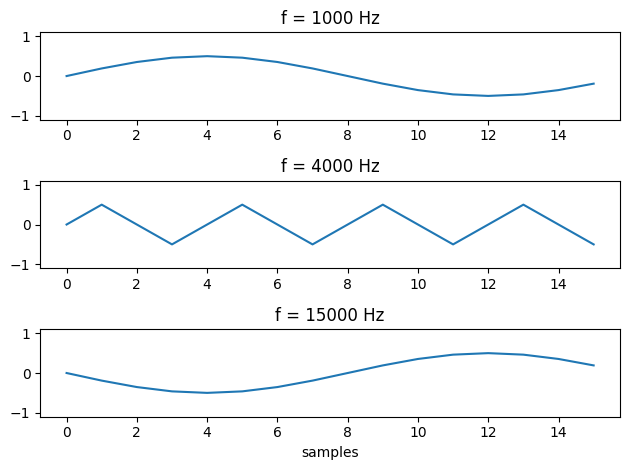

In [228]:
fs = 16_000
frequencies = [1_000, 4_000, 15_000]
amplitude = 0.5
N = fs
N_plot = int(0.001 * fs)

figure, axes_list = plt.subplots(3)

for axes, f in zip(axes_list, frequencies):
    x = generate_sin(N, f, fs) * amplitude
    axes.plot(x[:N_plot])
    axes.set_ylim([-1.1, 1.1])
    axes.set_title(f'f = {f} Hz')
    # save to file for listening
    filename = f"sine wave - {f} Hz.wav"
    sf.write(filename, x, fs)

axes_list[-1].set_xlabel('samples')
figure.tight_layout()

The sine signals with frequencies $ 1 $ and $ 4 \; kHz $ are perceived as expected because their frequency is less than $ fs / 2 $.
For the sine signal with frequency $ 15 \; kHz $, Aliasing occurs. The perceived frequency is $ fs - f = 1 \; kHz $. It sounds just like the first sine signal.